# Compute the metrics given the generated and the ground truth point cloud

In this notebook:
+ we generated point clouds using point-e300M. The point clouds were generated from data generated through ModelNet and ShapeNetV2. The data we initially found were textureless. Since the model is strongly affected by the color of the object in the views we tried to add the textures manually. The rgb textures we added to each point were produced with the sine function based on the position of the point in the 3d space.

+ Furthermore, in this notebook we compute the following metrics to evaluate the point clouds generated from the view/s:
  - Plots of the points pairwise distances distributions (explained [here](https://github.com/r1cc4r2o/point-e/blob/main/notebooks/2_evaluationMetricsExperiments.ipynb))
  - Point cloud divergences
      Compute the matrix of the pairwise euclidean distances between the points in the same cloud. From those matrix we compute the divergence between the point clouds with those metrics:
          > wasserstein_distance
          > gaussian (if specified)
  - [P-IS score](https://arxiv.org/pdf/1606.03498.pdf)
    + ground truth
    + single view
    + multi views
  - Batched [P-IS score](https://arxiv.org/pdf/1606.03498.pdf)
    + ground truth
    + single view
    + multi views
  - Batched [P-FID score](https://arxiv.org/pdf/1706.08500.pdf)
    + ground truth - single view
    + ground truth - multi views
  - Batched [Chamfer Distance](https://arxiv.org/pdf/2111.12702.pdf) 
    + ground truth - single view
    + ground truth - multi views


We outlined the Chamfer Distance and the plots of the points pairwise distances distributions [here](https://github.com/r1cc4r2o/point-e/blob/main/notebooks/2_evaluationMetricsExperiments.ipynb). 

### Inception Score P-IS

<p align="center">
  <img width="45%" src="/img/inception_classifier.png" />
</p>

Conceptually, Inception Score aims to evaluate how faithful the generated representation is. This is not an easy task. Typically are used models (called [inception classifiers]((https://arxiv.org/pdf/1606.03498.pdf))) that take the generated object as input and return likelihoods for each object category.
The authors of Point-e trained PointNet++ on the [release](https://arxiv.org/pdf/1706.02413.pdf). Afterwards, they trained the model over point clouds generated by meshes in ModelNet40. That trained Inception Classifier produces the likelihoods of each one of the 40 classes it was trained on. Thanks to the Inception Classifier we can measure how 
much the distribution of the generated objects are close to the distribution of a label. The score is computed as the exponential of the KL divergence.
##### KL divergence
![kl](https://wikimedia.org/api/rest_v1/media/math/render/svg/4958785faae58310ca5ab69de1310e3aafd12b32)

The P-IS is maximized when the distribution of the generated object is close to the distribution of a label and differ from the other labels.

### Inception Score P-FID

The P-FID is computed extracting the feature from the last layer before the final ReLU activation. Given those features we compute the [distance](https://en.wikipedia.org/wiki/Fréchet_inception_distance) between the generated distribution and the ground truth distribution.

##### Batched: means that we computed the score over batch of sample for 60 itarations

**Importing modules & loading if on GDrive/Colab**

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

import pytorch3d
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_obj, load_objs_as_meshes 
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex
)
from pytorch3d.io import IO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=b2c01d489bde86bab17455c9ac5565af3613bc800af4dd157d010d5bc55feaa1
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=657b285b11648e48b53b71a5fc4f1197a88856551a1695c26bcb1f74c3874301
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu116_pyt1131/dow

In [81]:
#!pip install trimesh # install trimesh
#import trimesh

#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
#from plot_image_grid import image_grid

from google.colab import files

import torch

import os
import sys
import glob
from PIL import Image, ImageDraw

import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.spatial import distance

import math

# Setup cuda
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [3]:
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import argparse
#from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

!git clone https://github.com/halixness/point-e.git
%cd ./point-e/

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.fid_is import compute_inception_score

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.fid_is import compute_inception_score
from point_e.evals.npz_stream import NpzStreamer

Cloning into 'point-e'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 213 (delta 59), reused 67 (delta 35), pack-reused 94
Receiving objects: 100% (213/213), 11.67 MiB | 36.89 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/point-e


#### Functions to compute the metrics:
- views_to_pointcloud: generate the model and produce the generated point cloud
- cloud_distance: compute the pair wise distance matrix between the points in the cloud
- plot_distributions: plot the distibutions of the observed distance matrix of the point cloud
- PIS: compute the [inception](https://arxiv.org/pdf/2206.10935.pdf) distance 
- batched_PIS: compute the PIS over a batch
- batched_PFID: compute the [batched_PFID](https://arxiv.org/pdf/2206.10935.pdf)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ToPILImage = transforms.ToPILImage()
num_points = 1024

In [5]:
def views_to_pointcloud(views, n_views=1):
    """ 
        Add zero color to a point cloud 
        in:     Tensor(n, w, h, 3), int(n)
        out:    Tensor(1, K, (x, y, z, r, g, b))
    """

    base_name = 'base300M' # base40M, use base300M or base1B for better results

    MODEL_CONFIGS[base_name]["n_views"] = n_views
    MODEL_CONFIGS['upsample']["n_views"] = n_views

    print('[-] creating base model...')
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    print('[-] creating upsample model...')
    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    print("[-] Loading pretrained models...")
    base_model.load_state_dict(load_checkpoint(base_name, device))
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))

    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )

    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
        samples = x

    del sampler
    del base_model
    del base_diffusion
    del upsampler_model
    del upsampler_diffusion
    return samples

# ----------------------------------------------
def cloud_distance(cloud1, cloud2, metric=None):
    """ 
        Compute distance between 1d distributions of cloud p2 norms 
        in:     Tensor((x, y, z), K), Tensor((x, y, z), K) 
        out:    Float
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"], idx=0):
    """ 
        Plot 1d distributions of cloud p2 norms 
        in:     Tensor(K, c), Tensor(K, c) 
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)

    # center the two pointcloud
    D1=torch.multiply(((D2).max()/(D1).max()),D1)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    
    plt.style.use('ggplot')
    s.plot.kde(bw_method=0.4,figsize=(24,8),title='poincloud distance pdf',logx=False ,linestyle='-',linewidth= 2).legend(fontsize=20, loc="upper right")
    plt.savefig(f"{idx}_{labels[0]}_{labels[1]}.jpg", bbox_inches='tight')
    plt.close()
    
def PIS(clf, cloud):
    """
        Compute P-IS score for a cloud
        in:     PointNetClassifier, Tensor(c, K)
        out:    Float
        https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
    """
    cloud = cloud.permute(1,0).unsqueeze(0).cpu().numpy()
    _, preds = clf.features_and_preds(cloud)

    return np.exp(
      np.sum(
        preds[0] * ( np.log(preds[0]) - np.log(np.mean(preds[0])) )
      )
    )

def batched_PIS(clf, clouds, batch_size=8):
    """
        Computes P-IS score for a batch of point clouds
        in:   (N, K, c)
        out:  (N, 40 = PointNet labels)
    """
    batches = math.ceil(clouds.shape[0] / batch_size)
    dataset_preds = None

    for x in range(batches):
        xs = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        _, preds = clf.features_and_preds(xs)

        if dataset_preds is None: dataset_preds = preds
        else: dataset_preds = np.concatenate((dataset_preds, preds), 0)
            
    return compute_inception_score(dataset_preds)

def batched_PFID(clf, ground_clouds, clouds, batch_size=8):
    """
        Computes P-FID score for pair of batches of point clouds
        in:   PointNetClassifier, (N, K, c), (N, K, c)
        out:  Float
    """
    batches = math.ceil(ground_clouds.shape[0] / batch_size)
    tot_features_1 = None
    tot_features_2 = None

    for x in range(batches):
        
        # Grab batched point clouds to compute the scores
        gnd = ground_clouds[(x * batch_size) : ((x + 1) * batch_size)]
        gen = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        
        features_1, _ = clf.features_and_preds(gnd)
        if tot_features_1 is None: tot_features_1 = features_1
        else: tot_features_1 = np.concatenate((tot_features_1, features_1), 0)
        del features_1

        features_2, _ = clf.features_and_preds(gen)
        if tot_features_2 is None: tot_features_2 = features_2
        else: tot_features_2 = np.concatenate((tot_features_2, features_2), 0)
        del features_2

    stats_1 = compute_statistics(tot_features_1)
    stats_2 = compute_statistics(tot_features_2)    
            
    return stats_1.frechet_distance(stats_2)

### Pre-processing the source datasets

In [ ]:
# modelnet_gencloud_300M = torch.cat((torch.load('./modelnet/modelnet0-20')[:20],torch.load('./modelnet/modelnet20-40')),0)
# shapenet_gencloud_300M = torch.cat((torch.load('./shapenet/shapenet_generated_clouds_backup0-23')[:24],torch.load('./shapenet/shapenet20-30')[4:11],torch.load('./shapenet/shapenet31-34'),torch.load('./shapenet/shapenet34')[0][None,:],torch.load('./shapenet/shapenet_generated_clouds_backup35-55')),0)
# torch.save(modelnet_gencloud_300M,'modelnet_texsin/modelnet_gencloud_300M')
# torch.save(shapenet_gencloud_300M,'shapenet_texsin/shapenet_gencloud_300M')

In [17]:
# !mkdir ./modelnet/
# !mkdir ./shapenet/
%cd ./modelnet/
!pwd
!unzip /content/modelnet.zip 
%cd ..
!pwd
%cd ./shapenet/
!pwd
!unzip /content/shapenet.zip 

/content/point-e/modelnet
/content/point-e/modelnet
Archive:  /content/modelnet.zip
  inflating: CLASS_MAP.pt            
  inflating: images_obj.pt           
  inflating: labels.pt               
  inflating: modelnet_gencloud_300M  
  inflating: points.pt               
/content/point-e
/content/point-e
/content/point-e/shapenet
/content/point-e/shapenet
Archive:  /content/shapenet.zip
  inflating: CLASS_MAP.pt            
  inflating: images_obj.pt           
  inflating: labels.pt               
  inflating: points.pt               
  inflating: shapenet_gencloud_300M  


In [ ]:
base_path = os.path.join("modelnet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))
CLASS_MAP = torch.load(os.path.join(base_path, 'CLASS_MAP.pt'))
categories = [CLASS_MAP[i] for i in CLASS_MAP.keys()]
gen_clouds = torch.load(os.path.join(base_path, 'modelnet_gencloud_300M'))


In [21]:
base_path = os.path.join("shapenet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))
CLASS_MAP = torch.load(os.path.join(base_path, 'CLASS_MAP.pt'))
categories = [CLASS_MAP[i] for i in CLASS_MAP.keys()]
gen_clouds = torch.load(os.path.join(base_path, 'shapenet_gencloud_300M'))

In [ ]:
ground_objs = []
limit = 30

for i in range(views.shape[0]):
    ground_objs.append([ToPILImage(views[i, j, :, :, :3]) for j in range(4)])

**Generating the point clouds for ShapeNet**

In [ ]:
gen_clouds = torch.zeros((len(ground_objs), 2, 6, 4096)) # N, 2, c, K

for i, obj in enumerate(ground_objs):
    
    torch.cuda.empty_cache()

    # Point cloud from single view
    print(f"====== Category {categories[i]} ======")
    print("====== Single view ======")
    gen_clouds[i, 0, :, :] = views_to_pointcloud(views = [obj[0]], n_views = 1)

    torch.cuda.empty_cache()

    # Point cloud from multi view
    print("\n====== Multi view ======")
    gen_clouds[i, 1, :, :] = views_to_pointcloud(views = obj, n_views = len(obj))

    # do a backup of the current version 
    torch.save(gen_clouds,'./'+base_path+'Backup') # store the generated point cloud
    
    torch.cuda.empty_cache()
    
    if i == limit: break

# Calculate the metrics over the generated point cloud from ShapeNet

In [ ]:
base_path = os.path.join("shapenet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))
CLASS_MAP = torch.load(os.path.join(base_path, 'CLASS_MAP.pt'))
categories = [CLASS_MAP[i] for i in CLASS_MAP.keys()]
gen_clouds = torch.load(os.path.join(base_path, 'shapenet_gencloud_300M'))

<bound method Axes3D.set_axis_off of <matplotlib.axes._subplots.Axes3DSubplot object at 0x00000203925C1850>>

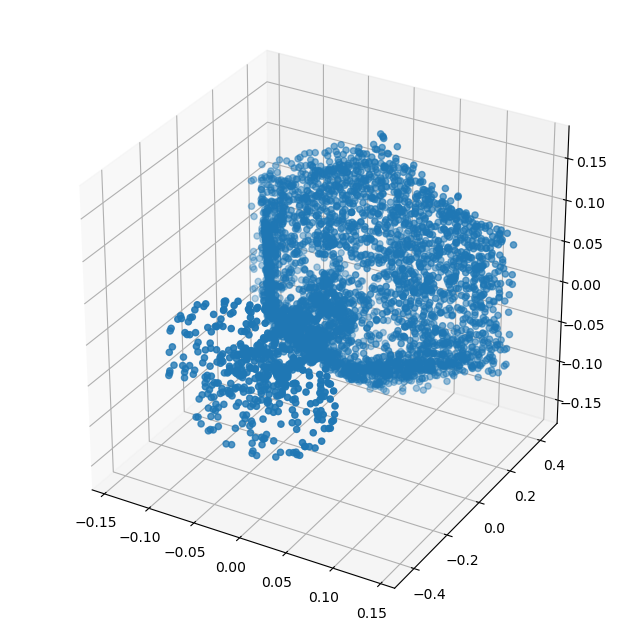

In [ ]:
points=torch.load('./shapenet_texsin/points.pt')[2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off

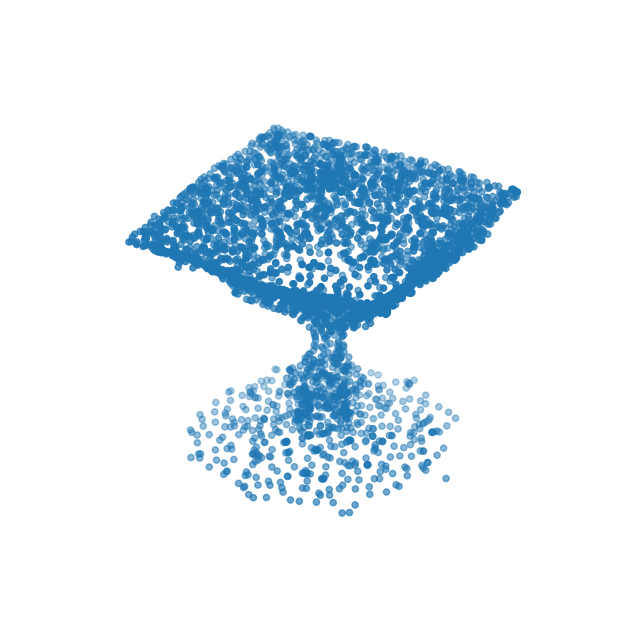

In [ ]:
points = torch.load('shapenet_texsin/shapenet_gencloud_300M')[2]
points = points[1].permute(1,0) # model with multi views conditioning
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

**Loading PointNet to compute P-IS, P-FID**

In [ ]:
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)

In [ ]:
scores = torch.zeros((gen_clouds.shape[0], 3))
eval_cloud = dict()
point_clouds = torch.load(os.path.join(base_path, "points.pt"))

# Iterating through the generated clouds, given also the ground clouds
for i, c in zip(range(gen_clouds.shape[0]),categories):
    l=[]
    print(f"\n====== [{i}] Point cloud divergences ======")
    
    # ---- Ground - Gen. single
    d_ground_single = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 0, :3, :].permute(1,0)
    )
    l.append(('d_ground_single',d_ground_single))

    print("[+] Ground truth - Single view divergence: \t\t{}".format(d_ground_single))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 0, :3, :].permute(1,0),
        ["ground_truth", "single view"], 
        i
    )
    idx=i
    labels=["ground_truth", "single view"]
    l.append(("ground_truth_single_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))
    # ---- Ground - Gen. multi
    d_ground_multi = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    l.append(('d_ground_multi',d_ground_multi))

    print("[+] Ground truth - Multi view divergence: \t\t{}".format(d_ground_multi))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["ground_truth", "multi view"], 
        i
    )
    idx=i
    labels=["ground_truth", "multi view"]
    l.append(("ground_truth_multi_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))

    # ---- Gen. single - Gen. multi
    d_single_multi = cloud_distance(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0),
    )
    l.append(('d_single_multi',d_single_multi))

    print("[+] Single view - Multi view divergence: \t\t{}".format(d_single_multi))

    plot_distributions(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["single view", "multi view"], 
        i
    )
    idx=i
    labels=["single view", "multi view"]
    l.append(("single_multi_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))
    # compute the P-IS
    print(f"[+] Ground truth P-IS: \t\t{PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))}")
    l.append(('ground_truth_pis',PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))))
    print(f"[+] Single view P-IS: \t\t{PIS(clf, gen_clouds[i, 0, :3, :])}")
    l.append(('single_view_pis',PIS(clf, gen_clouds[i, 0, :3, :])))
    print(f"[+] Multi view P-IS: \t\t{PIS(clf, gen_clouds[i, 1, :3, :])}")
    l.append(('multi_view_pis',PIS(clf, gen_clouds[i, 1, :3, :])))

    # store pointclouds
    l.append(('ground_truth_cloud',torch.Tensor(point_clouds[i])))
    l.append(('g_single_view_cloud',gen_clouds[i,0].permute(1,0)))
    l.append(('g_multi_view_cloud',gen_clouds[i,1].permute(1,0)))
    
    scores[i, :] = torch.Tensor([d_ground_single, d_ground_multi, d_single_multi])
    
    eval_cloud[c] = l
    

The size of the batch is based on *size_point_cloud/3*. Fixed the size of the batch we iterate this procedure:
- produce random batch of the (generated cloud, ground truth cloud)
- store the value of batched_PIS, batched_PFID, chamfer_distance over the random generated batch

In [ ]:
import random
batch_size = int(point_clouds.shape[0]/3)
iterations = 60
batch_pfid = []
batch_pfis = []
batch_chamferdistance = []


clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)


for i in range(iterations):

  print('==================iteration: ',i)

  batch = random.sample(range(point_clouds.shape[0]),k=batch_size)

  # generated with single view
  gc0 = np.concatenate([r[0,:3].permute(1,0).numpy()[None,:] for r in [gen_clouds[index] for index in batch]],axis=0) 

  # generated with multiple views
  gc1 = np.concatenate([r[1,:3].permute(1,0).numpy()[None,:] for r in [gen_clouds[index] for index in batch]],axis=0) 

  # ground truth point cloud
  pc = np.concatenate([torch.Tensor(r).cpu().numpy()[None,:] for r in [point_clouds[index] for index in batch]],axis=0) 

  # (batched_PFID(single view, ground truth), batched_PFID(multiple view, ground truth))
  batch_pfid.append((batched_PFID(clf, gc0, pc, batch_size=batch_size), batched_PFID(clf, gc1, pc, batch_size=batch_size))) 

  # (batched_PIS(ground truth), batched_PIS(single view), batched_PIS(multiple view))
  batch_pfis.append((batched_PIS(clf, pc, batch_size=batch_size), batched_PIS(clf, gc0, batch_size=batch_size), batched_PIS(clf, gc1, batch_size=batch_size)))

  # (chamfer_distance(single view, ground truth), chamfer_distance(multiple view, ground truth))
  batch_chamferdistance.append((chamfer_distance(torch.Tensor(gc0), torch.Tensor(pc)), chamfer_distance(torch.Tensor(gc1), torch.Tensor(pc))))

In [ ]:
# batch_pfid: (b_pfidSingleGround, b_pfidMultipleGround)

b_pfidSingleGround, b_pfidMultipleGround = [], []
[b_pfidSingleGround.append(i[0]) for i in batch_pfid]
[b_pfidMultipleGround.append(i[1]) for i in batch_pfid]

# batch_pis: (b_pisGround, b_pisSingle, b_pisMultiple)

b_pisGround, b_pisSingle, b_pisMultiple = [], [], []
[b_pisGround.append(i[0]) for i in batch_pfis]
[b_pisSingle.append(i[1]) for i in batch_pfis]
[b_pisMultiple.append(i[2]) for i in batch_pfis]

# batch_chamferdistance: (b_cdSingleGround, b_cdMultipleGround)

b_cdSingleGround, b_cdMultipleGround = [], []
[b_cdSingleGround.append(float(i[0][0])) for i in batch_chamferdistance]
[b_cdMultipleGround.append(float(i[1][0])) for i in batch_chamferdistance]

df_score = pd.DataFrame()

df_score['b_pfidSingleGround'] = b_pfidSingleGround
df_score['b_pfidMultipleGround'] = b_pfidMultipleGround
df_score['b_pisGround'] = b_pisGround
df_score['b_pisSingle'] = b_pisSingle
df_score['b_pisMultiple'] = b_pisMultiple
df_score['b_cdSingleGround'] = b_cdSingleGround
df_score['b_cdMultipleGround'] = b_cdMultipleGround

In [75]:
# df of the scores
df_score

,b_pfidSingleGround,b_pfidMultipleGround,b_pisGround,b_pisSingle,b_pisMultiple,b_cdSingleGround,b_cdMultipleGround
0,92.471725,151.786826,10.845221,8.692645,7.204420,0.109505,0.084359
1,78.847034,150.276559,9.715955,7.906904,6.968372,0.071465,0.081416
2,105.290869,163.732346,7.676904,8.598829,8.294290,0.078049,0.090337
3,87.591422,127.365016,7.950496,7.273118,7.102124,0.074593,0.067453
4,79.021277,129.263608,9.109818,10.054539,8.365810,0.073371,0.081866
5,108.429239,143.820873,8.822457,8.691772,6.462906,0.102707,0.057896
6,99.062165,128.991151,11.222360,10.099483,7.065252,0.087003,0.067811
7,99.125253,129.637346,8.154959,6.705756,7.818442,0.066122,0.065232
8,79.333206,136.536248,12.656800,10.250855,9.203143,0.071511,0.096059
9,108.846774,125.969543,9.021049,9.334896,9.385340,0.111829,0.065333


In [ ]:
df_score.to_csv('df_score_shapenet.csv', index=False)

In [ ]:
import pickle

# save the file in the folder
with open(os.path.join(base_path, 'eval_clouds_shapenet.pickle'), 'wb') as handle:
    pickle.dump(eval_cloud, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# to store the file in drive
import shutil
shutil.copy(os.path.join(base_path, 'eval_clouds_shapenet.pickle'), "/content/drive/MyDrive/eval_clouds_shapenet.pickle")

# Calculate the metrics over the generated point cloud from ModelNet

In [76]:
base_path = os.path.join("modelnet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))
CLASS_MAP = torch.load(os.path.join(base_path, 'CLASS_MAP.pt'))
categories = [CLASS_MAP[i] for i in CLASS_MAP.keys()]
gen_clouds = torch.load(os.path.join(base_path, 'modelnet_gencloud_300M'))

In [ ]:
scores = torch.zeros((gen_clouds.shape[0], 3))
eval_cloud = dict()
point_clouds = torch.load(os.path.join(base_path, "points.pt"))


for i, c in zip(range(gen_clouds.shape[0]),categories):
    l=[]
    print(f"\n====== [{i}] Point cloud divergences ======")
    
    # ---- Ground - Gen. single
    d_ground_single = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 0, :3, :].permute(1,0)
    )
    l.append(('d_ground_single',d_ground_single))

    print("[+] Ground truth - Single view divergence: \t\t{}".format(d_ground_single))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 0, :3, :].permute(1,0),
        ["ground_truth", "single view"], 
        i
    )
    idx=i
    labels=["ground_truth", "single view"]
    l.append(("ground_truth_single_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))
    # ---- Ground - Gen. multi
    d_ground_multi = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    l.append(('d_ground_multi',d_ground_multi))

    print("[+] Ground truth - Multi view divergence: \t\t{}".format(d_ground_multi))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["ground_truth", "multi view"], 
        i
    )
    idx=i
    labels=["ground_truth", "multi view"]
    l.append(("ground_truth_multi_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))

    # ---- Gen. single - Gen. multi
    d_single_multi = cloud_distance(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0),
    )
    l.append(('d_single_multi',d_single_multi))

    print("[+] Single view - Multi view divergence: \t\t{}".format(d_single_multi))

    plot_distributions(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["single view", "multi view"], 
        i
    )
    idx=i
    labels=["single view", "multi view"]
    l.append(("single_multi_view",Image.open(f"{idx}_{labels[0]}_{labels[1]}.jpg")))
    # compute the P-IS
    print(f"[+] Ground truth P-IS: \t\t{PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))}")
    l.append(('ground_truth_pis',PIS(clf, torch.Tensor(point_clouds[i]).permute(1,0))))
    print(f"[+] Single view P-IS: \t\t{PIS(clf, gen_clouds[i, 0, :3, :])}")
    l.append(('single_view_pis',PIS(clf, gen_clouds[i, 0, :3, :])))
    print(f"[+] Multi view P-IS: \t\t{PIS(clf, gen_clouds[i, 1, :3, :])}")
    l.append(('multi_view_pis',PIS(clf, gen_clouds[i, 1, :3, :])))

    # store pointclouds
    l.append(('ground_truth_cloud',torch.Tensor(point_clouds[i])))
    l.append(('g_single_view_cloud',gen_clouds[i,0].permute(1,0)))
    l.append(('g_multi_view_cloud',gen_clouds[i,1].permute(1,0)))

    scores[i, :] = torch.Tensor([d_ground_single, d_ground_multi, d_single_multi])
    
    eval_cloud[c] = l
    


====== [0] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		63.172182841642055
[+] Ground truth - Multi view divergence: 		203.4773053122496
[+] Single view - Multi view divergence: 		140.30873837143076
[+] Ground truth P-IS: 		8.7105131149292
[+] Single view P-IS: 		34.55952072143555
[+] Multi view P-IS: 		15.775752067565918

====== [1] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		87.98316256787841
[+] Ground truth - Multi view divergence: 		82.0805693469262
[+] Single view - Multi view divergence: 		10.904746495299378
[+] Ground truth P-IS: 		30.042991638183594
[+] Single view P-IS: 		11.263814926147461
[+] Multi view P-IS: 		34.20673751831055

====== [2] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		50.12974867737996
[+] Ground truth - Multi view divergence: 		68.07494954115812
[+] Single view - Multi view divergence: 		17.945200863778155
[+] Ground truth P-IS: 		8.884458541870117
[+] Single vie

In [ ]:
import pickle

# save the file in the folder
with open(os.path.join(base_path, 'eval_clouds_modelnet_300M.pickle'), 'wb') as handle:
    pickle.dump(eval_cloud, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import shutil
shutil.copy(os.path.join(base_path, 'eval_clouds_modelnet_300M.pickle'), "/content/drive/MyDrive/eval_clouds_modelnet_300M.pickle")

In [ ]:
with open('eval_clouds.pickle', 'rb') as handle:
    eval_b = pickle.load(handle)

The size of the batch is based on *size_point_cloud/3*. Fixed the size of the batch we iterate this procedure:
- produce random batch of the (generated cloud, ground truth cloud)
- store the value of batched_PIS, batched_PFID, chamfer_distance over the random generated batch

In [77]:
import random
batch_size = int(point_clouds.shape[0]/3)
iterations = 60
batch_pfid = []
batch_pfis = []
batch_chamferdistance = []


clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)


for i in range(iterations):

  print('==================iteration: ',i)

  batch = random.sample(range(point_clouds.shape[0]),k=batch_size)

  # generated with single view
  gc0 = np.concatenate([r[0,:3].permute(1,0).numpy()[None,:] for r in [gen_clouds[index] for index in batch]],axis=0) 

  # generated with multiple views
  gc1 = np.concatenate([r[1,:3].permute(1,0).numpy()[None,:] for r in [gen_clouds[index] for index in batch]],axis=0) 

  # ground truth point cloud
  pc = np.concatenate([torch.Tensor(r).cpu().numpy()[None,:] for r in [point_clouds[index] for index in batch]],axis=0) 

  # (batched_PFID(single view, ground truth), batched_PFID(multiple view, ground truth))
  batch_pfid.append((batched_PFID(clf, gc0, pc, batch_size=batch_size), batched_PFID(clf, gc1, pc, batch_size=batch_size))) 

  # (batched_PIS(ground truth), batched_PIS(single view), batched_PIS(multiple view))
  batch_pfis.append((batched_PIS(clf, pc, batch_size=batch_size), batched_PIS(clf, gc0, batch_size=batch_size), batched_PIS(clf, gc1, batch_size=batch_size)))

  # (chamfer_distance(single view, ground truth), chamfer_distance(multiple view, ground truth))
  batch_chamferdistance.append((chamfer_distance(torch.Tensor(gc0), torch.Tensor(pc)), chamfer_distance(torch.Tensor(gc1), torch.Tensor(pc))))

==================iteration:  0
==================iteration:  1
==================iteration:  2
==================iteration:  3
==================iteration:  4
==================iteration:  5
==================iteration:  6
==================iteration:  7
==================iteration:  8
==================iteration:  9
==================iteration:  10
==================iteration:  11
==================iteration:  12
==================iteration:  13
==================iteration:  14
==================iteration:  15
==================iteration:  16
==================iteration:  17
==================iteration:  18
==================iteration:  19
==================iteration:  20
==================iteration:  21
==================iteration:  22
==================iteration:  23
==================iteration:  24
==================iteration:  25
==================iteration:  26
==================iteration:  27
==================iteration:  28
==================iteration:  29
==================it

Thus, we initialize the list and we produce a df with ours scores

In [78]:
# batch_pfid: (b_pfidSingleGround, b_pfidMultipleGround)

b_pfidSingleGround, b_pfidMultipleGround = [], []
[b_pfidSingleGround.append(i[0]) for i in batch_pfid]
[b_pfidMultipleGround.append(i[1]) for i in batch_pfid]

# batch_pis: (b_pisGround, b_pisSingle, b_pisMultiple)

b_pisGround, b_pisSingle, b_pisMultiple = [], [], []
[b_pisGround.append(i[0]) for i in batch_pfis]
[b_pisSingle.append(i[1]) for i in batch_pfis]
[b_pisMultiple.append(i[2]) for i in batch_pfis]

# batch_chamferdistance: (b_cdSingleGround, b_cdMultipleGround)

b_cdSingleGround, b_cdMultipleGround = [], []
[b_cdSingleGround.append(float(i[0][0])) for i in batch_chamferdistance]
[b_cdMultipleGround.append(float(i[1][0])) for i in batch_chamferdistance]

df_score = pd.DataFrame()

df_score['b_pfidSingleGround'] = b_pfidSingleGround
df_score['b_pfidMultipleGround'] = b_pfidMultipleGround
df_score['b_pisGround'] = b_pisGround
df_score['b_pisSingle'] = b_pisSingle
df_score['b_pisMultiple'] = b_pisMultiple
df_score['b_cdSingleGround'] = b_cdSingleGround
df_score['b_cdMultipleGround'] = b_cdMultipleGround

In [79]:
df_score.to_csv('df_score_modelnet.csv', index=False)

In [80]:
df_score

,b_pfidSingleGround,b_pfidMultipleGround,b_pisGround,b_pisSingle,b_pisMultiple,b_cdSingleGround,b_cdMultipleGround
0,140.424799,152.303771,11.611675,7.417374,7.405140,1.096978e+05,1.097293e+05
1,152.812093,161.110250,10.681616,6.617743,7.782906,1.167581e+05,1.167828e+05
2,172.436354,137.831592,10.251635,6.993407,7.454226,5.334963e+04,5.336064e+04
3,187.515082,182.953544,10.474554,6.707609,5.925267,1.092885e+05,1.093060e+05
4,155.044586,165.704505,9.738242,7.251688,5.293271,9.594891e+03,9.613583e+03
5,140.317896,170.814513,10.928599,6.590900,7.523105,1.096095e+05,1.096266e+05
6,187.345031,170.097690,10.243130,7.377587,6.196292,1.529263e+04,1.531029e+04
7,145.798382,170.394712,10.938588,6.516793,5.581453,2.993162e+04,2.994007e+04
8,149.323252,191.883221,11.166759,7.016579,6.997209,1.470898e+05,1.471269e+05
9,149.118007,182.565543,8.834334,8.469821,8.358832,4.716669e+04,4.718945e+04


In [82]:
files.download("df_score_modelnet.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>